## **Import package**

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 532.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 1.6 MB/s eta 0:00:00


In [ ]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 6.4 MB/s eta 0:00:00


In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.model_selection import GridSearchCV

from tensorflow.keras import Input, models, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

## **Load the Data**

Since the file is too large to upload conveniently, we stored the dataset in Google Drive and set the sharing permissions accordingly. By running the following code chunk, the dataset will be imported and unzipped directly into the specified directory.

Originally, the training data was split into six files (train_features_0.jsonl to train_features_5.jsonl). However, importing all of them would be too large, quickly consume RAM, and significantly slow down execution. After discussing with Professor Ding, we decided to import only one of the files. Upon inspection, we found that train_features_0.jsonl contains only data with label = 0, so we ultimately chose to use train_features_1.jsonl only.

In [ ]:
# Load and unzip the file
# Only use train_features_1
file_id = "1JnIrOotQjCSFvi9pZ1hApEia78g0RmUN"
!gdown --id {file_id} --output Meng-Hsuan_Te-Jou_data.zip
!unzip Meng-Hsuan_Te-Jou_data.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1JnIrOotQjCSFvi9pZ1hApEia78g0RmUN
From (redirected): https://drive.google.com/uc?id=1JnIrOotQjCSFvi9pZ1hApEia78g0RmUN&confirm=t&uuid=a60d46b4-7b21-4bd7-9e5b-139d3140065d
To: /content/Meng-Hsuan_Te-Jou_data.zip
100% 864M/864M [00:07<00:00, 123MB/s]
Archive:  Meng-Hsuan_Te-Jou_data.zip
   creating: data_ember_2018/
  inflating: data_ember_2018/.DS_Store  
  inflating: __MACOSX/data_ember_2018/._.DS_Store  
   creating: data_ember_2018/test/
   creating: data_ember_2018/train/
  inflating: data_ember_2018/test/test_features.jsonl  
  inflating: __MACOSX/data_ember_2018/test/._test_features.jsonl  
  inflating: data_ember_2018/train/train_features_1.jsonl  
  inflating: __MACOSX/data_ember_2018/train/._train_fe

In [ ]:
# Function to load JSONL files into a pandas DataFrame
def get_jsonl_data(data_path):
  data_frames = []
  # Iterate through all jsonl files in the directory
  for file in os.listdir(data_path):
    if file.endswith(".jsonl"):
      file_path = os.path.join(data_path, file)
      with open(file_path, "r") as f:
        data = [json.loads(line) for line in f]
        df = pd.DataFrame(data)
        data_frames.append(df)
  # Combine all dataframes into one
  if data_frames:
    return pd.concat(data_frames, ignore_index=True)
  else:
    return pd.DataFrame()

train_set = get_jsonl_data("./data_ember_2018/train")
test_set = get_jsonl_data("./data_ember_2018/test")

In [ ]:
# Display first few rows of training and testing data
print("Training Data:")
print(train_set.head())

print("\nTest Data:")
print(test_set.head())

Training Data:
                                              sha256  \
0  2ef9a92ee6c955364564b0df75ee3753473014b2ba162b...   
1  50f3f85a10cedf9192f7aa4cd4d2b1ce9e294e23f3dd7e...   
2  f6c68207b3b395feabcbb029c393607db4ff5227ecd5da...   
3  3292ee48fac44b7b70bdfde526f71c09e65764d9b582f5...   
4  b9494c218b74a9774a88307ba83c03da0bee3a80899b47...   

                                md5 appeared  label    avclass  \
0  7e39aeea7bc21d16b8652516a150b282  2018-01      1      sivis   
1  09435239e7a0ddfeb78820cf5c31cc06  2018-01     -1     upatre   
2  744cac35cdfa2c3a0672184d433cb93e  2018-01      0              
3  b6d6f2dc5ef191e23dfc2892ff626168  2018-01      0              
4  b6607d4123b0d3afdbca4bdc9a4bcf7a  2018-01     -1  startsurf   

                                           histogram  \
0  [60782, 5895, 2020, 1487, 2075, 1367, 1145, 85...   
1  [11971, 74, 27, 147, 61, 61, 19, 27, 53, 34, 1...   
2  [35534, 3516, 1832, 870, 957, 596, 435, 501, 1...   
3  [3389, 100, 35, 9, 18, 7

## **Data Preprocessing**

1. **Feature Selection**

   Since the dataset contains too many features, it can lead to issues such as the curse of dimensionality, slower model training, and excessive consumption of computational resources. Therefore, we consulted ChatGPT to understand the meaning of each column and assess its usefulness in training a malware families classifier, using that information as the basis for our feature selection. Below are the features recommended by ChatGPT for inclusion in the model:

  a. *general*:
      - Basic file attributes such as file size, presence of UPX packing, etc.
      - Low-dimensional but highly informative for differentiating families.

  b. *header*:
      - PE header features like machine type, number of sections, compile timestamp.
      - Reflects malware origin and build characteristics.

  c. *histogram* (first 100 dimensions only):
      - Byte frequency distribution (originally 256-dim).
      - Using only first 50–100 dimensions helps reduce memory usage while retaining effectiveness.

  d. *strings* (summary features only):
      - Includes: numstrings, average length, entropy, and counts of paths/urls/registry.
      - Reveals presence of hardcoded URLs, suspicious commands, or registry entries.

  e. *imports* (summary only):
      - Only count the number of imported DLL functions.
      - Avoid expanding full import API names to prevent feature explosion.

2. **Flatten the data**:

   This dataset contains many nested columns with different structures. However, the models we are using (Decision Tree, Random Forest, and CNN) do not support nested columns. Therefore, we need to flatten the features we intend to use before feeding them into the models.


In [ ]:
def flatten_selected_columns(df):
    flat_df = pd.DataFrame()

    # No need to flatten
    for col in df.columns:
        if col not in ['general', 'header', 'histogram', 'strings', 'imports']:
            flat_df[col] = df[col]

    # 1. flatten general
    if 'general' in df.columns:
        general_df = pd.json_normalize(df['general'])
        general_df.columns = [f'general_{col}' for col in general_df.columns]
        flat_df = pd.concat([flat_df, general_df], axis=1)

    # 2. flatten header.coff only
    if 'header' in df.columns:
        header_df = df['header'].apply(lambda x: x.get('coff', {}) if isinstance(x, dict) else {}).apply(pd.Series)
        header_df.columns = [f'header_{col}' for col in header_df.columns]
        flat_df = pd.concat([flat_df, header_df], axis=1)

    # 3. flatten histogram (first 100)
    if 'histogram' in df.columns:
        hist_df = df['histogram'].apply(lambda x: x[:100] if isinstance(x, list) else [0]*100)
        hist_df = pd.DataFrame(hist_df.tolist(), columns=[f'hist_{i}' for i in range(100)])
        flat_df = pd.concat([flat_df, hist_df], axis=1)

    # 4. flatten strings
    if 'strings' in df.columns:
        strings_df = pd.json_normalize(df['strings'])
        strings_stat_cols = ['numstrings', 'avlength', 'entropy', 'printable']

        for col in strings_stat_cols:
            if col not in strings_df.columns:
                strings_df[col] = np.nan

        for col in ['urls', 'paths', 'registry']:
            strings_df[f'{col}_count'] = df['strings'].apply(
                lambda x: len(x.get(col)) if isinstance(x, dict) and isinstance(x.get(col), list) else 0
            )

        selected_cols = strings_stat_cols + [f'{c}_count' for c in ['urls', 'paths', 'registry']]
        strings_df = strings_df[selected_cols].fillna(0)
        strings_df.columns = [f'strings_{col}' for col in strings_df.columns]
        flat_df = pd.concat([flat_df, strings_df], axis=1)

    # 5. flatten imports (Only DLL)
    if 'imports' in df.columns:
        imports_df = df['imports'].apply(lambda x: len(x) if isinstance(x, dict) else 0)
        flat_df['imports_count'] = imports_df

    return flat_df

In [ ]:
train_flatten = flatten_selected_columns(train_set)

In [ ]:
test_flatten = flatten_selected_columns(test_set)

In [ ]:
# Flatten the "header_machine" column
mlb_machine = MultiLabelBinarizer()

# Apply fit_transform to the training set
machine_features_train = mlb_machine.fit_transform(train_flatten['header_machine'])
machine_df_train = pd.DataFrame(machine_features_train, columns=mlb_machine.classes_, index=train_flatten.index)
train_flatten = pd.concat([train_flatten, machine_df_train], axis=1)
train_flatten = train_flatten.drop(columns=['header_machine'])

# Apply transform only to the testing set
machine_features_test = mlb_machine.transform(test_flatten['header_machine'])
machine_df_test = pd.DataFrame(machine_features_test, columns=mlb_machine.classes_, index=test_flatten.index)
test_flatten = pd.concat([test_flatten, machine_df_test], axis=1)
test_flatten = test_flatten.drop(columns=['header_machine'])

In [ ]:
# Flatten the "header_characteristics" column
mlb_characteristics = MultiLabelBinarizer()

# Apply fit_transform to the training set
machine_features_train = mlb_characteristics.fit_transform(train_flatten['header_characteristics'])
machine_df_train = pd.DataFrame(machine_features_train, columns=mlb_characteristics.classes_, index=train_flatten.index)
train_flatten = pd.concat([train_flatten, machine_df_train], axis=1)
train_flatten = train_flatten.drop(columns=['header_characteristics'])

# Apply transform only to the testing set
machine_features_test = mlb_characteristics.transform(test_flatten['header_characteristics'])
machine_df_test = pd.DataFrame(machine_features_test, columns=mlb_characteristics.classes_, index=test_flatten.index)
test_flatten = pd.concat([test_flatten, machine_df_test], axis=1)
test_flatten = test_flatten.drop(columns=['header_characteristics'])

3. **Filtering for Malicious Data**

   In this dataset, label = 1 indicates Malicious, label = 0 represents Benign, and label = -1 denotes Unlabeled data (possibly from the test set). Since our goal is to identify the malware family associated with each malicious sample, we removed all data with labels 0 and -1.

In [ ]:
train_flatten['label'].value_counts()
# 1 = Malicious; 0 = Benign; -1 = Unlabeled (possibly the test set)
# label 1 = 63713; label 0 = 52338; label -1 = 42107

,count
label,
1,63713
0,52338
-1,42107


In [ ]:
test_flatten['label'].value_counts()
# label 1 = 100000; label 0 = 100000

,count
label,
1,100000
0,100000


In [ ]:
# Remove the data with label = 0 or -1
malware_train_set = train_flatten[train_flatten['label'] == 1]
malware_test_set = test_flatten[test_flatten['label'] == 1]

4. **Merge the malware family class(avclass) into broader categories**

   Since the original dataset contains too many malware family categories, the model has difficulty learning from classes with few samples. This often leads to the model ignoring smaller classes and struggling to effectively learn distinguishing features between categories. Additionally, training time and resource consumption increase significantly.

   To address this, we listed all categories in the dataset’s avclass column and consulted both ChatGPT and Gemini for suggestions on how to merge them appropriately. We then compared their responses and also referred to the following four websites:

  **Sources**

   *   **VirusTotal (VT)** : https://www.virustotal.com/gui/home
   *   **Kaspersky Threat** Intelligence Portal : https://threats.kaspersky.com/
   * **Malpedia** : https://malpedia.caad.fkie.fraunhofer.de/
   * **Microsoft Security Intelligence (Threat Encyclopedia)** : https://www.microsoft.com/en-us/wdsi/threats

   We consolidated these insights into our final merged classification scheme:

   **General Category**

   * **Trojan**: Disguises itself as legitimate software to perform malicious actions
   * **Ransomware**: Encrypts files or locks the system, demanding a ransom
   * **Adware**: Forcibly displays advertisements
   * **Downloader**: Primary function is to download and execute other malware
   * **Worm**: Self-replicates and spreads across networks
   * **Virus**: Infects other files or code
   * **Backdoor**: Provides remote access to the compromised system
   * **Spyware**: Steals user information
   * **Botnet Client**: Turns the infected machine into part of a botnet under remote control
   * **PUA (Potentially Unwanted Application)**: May not be purely malicious but exhibits undesirable or risky behavior
   * **Riskware**: Legitimate software with functionalities that could potentially be misused for security risks or unwanted actions (similar to PUA).
   * **RAT (Remote Access Trojan)**: Malware giving attackers unauthorized, full remote control over a victim's computer for spying, data theft, or launching other attacks.
   * **Generic**: An antivirus detection label indicating a file matches broad malware patterns or suspicious behavior, rather than a specific known family.

   Next, for classes with very few samples, we grouped them under a unified "Others" category to prevent the number of classes from remaining too high even after merging.

   Additionally, we treated the data with missing avclass values as "Unknown." Upon inspection, these samples accounted for only 5.68% of the training dataset. Since data without avclass provides no useful information for training our model, we removed all of them.

In [ ]:
# Define the mapping dictionary
avclass_mapping = {
  "installmonster" : "PUA",
  "zusy" : "Botnet", #Zeus/Zbot variant
  "fareit" : "Trojan", #Information Stealer (passwords, credentials)
  "adposhel" : "Adware",
  "" : "Unknown",
  "dealply" : "Adware", #Adware/Shopping Assistant
  "emotet" : "Trojan", #Advanced modular banking Trojan
  "high" : "Generic", #Often a generic detection label
  "startsurf" : "Adware", #Browser Hijacker/Adware
  "dotdo" : "Adware", #Associated with Adware or PUA
  "tiggre" : "Downloader", #Often acts as a downloader or dropper
  "vittalia" : "Adware",
  "moderate" : "Adware",
  "qhost" : "RAT", #Ghost RAT
  "wannacry" : "Ransomware", #Infamous ransomware worm
  "sality" : "Virus", #Polymorphic file infector and P2P botnet/worm
  "soft32downloader" : "Downloader",
  "upatre" : "Downloader", #often used to deliver other payloads like Dyre
  "zbot" : "Trojan", #Zeus banking trojan
  "razy" : "Trojan",
  "gamarue" : "Worm", #Also known as Andromeda, modular botnet/worm
  "gamehack" : "Riskware", #Game cracking tools, often bundled with malware or riskware
  "mira" : "Trojan",
  "virut" : "Virus", #Polymorphic file infector and IRC botnet
  "delf" : "Trojan", #Generic term for Trojans written in Delphi
  "autoit" : "Trojan", #Legitimate scripting tool, often abused by malware authors
  "virlock" : "Ransomware", #File-infecting ransomware (locks screen and encrypts)
  "filetour" : "Downloader", #Often bundled with torrent clients
  "ramnit" : "Worm",
  "tinba" : "Spyware", #"Tiny Banker" Trojan, info stealer
  "bladabindi" : "RAT", #NJRat variant, common RAT
  "nymaim" : "Downloader",
  "installcore" : "PUA", #Common PUA bundler/installer platform
  "vobfus" : "Worm", #Worm spreading via removable drives, downloads other malware
  "icloader" : "Downloader", #Malware downloader
  "ausiv" : "Trojan",
  "slimware" : "PUA", #SlimCleaner PUA
  "istartsurf" : "Adware", #Browser Hijacker/Adware
  "wabot" : "Botnet",
  "loadmoney" : "Ransomware",
  "yakes" : "Trojan",
  "eorezo" : "Adware",
  "qbot" : "Trojan", #Also known as QakBot, banking trojan, worm features
  "scar" : "RAT",
  "ursu" : "Trojan", #Likely related to Ursnif family
  "darkkomet" : "RAT", #DarkComet Remote Access Trojan
  "prepscram" : "Trojan", #Often associated with obfuscated script-based Trojans
  "msilperseus" : "RAT", #Perseus RAT
  "gepys" : "Trojan",
  "poison" : "RAT", #Poison Ivy is a RAT
  "linkury" : "Adware", #Adware family
  "ircbot" : "Botnet",
  "qqpass" : "Spyware", #QQ Password Stealer
  "regsup" : "PUA", #Registry Cleaner PUA
  "agen" : "Trojan", #Generic "Agent" tag, often a Trojan or Backdoor component
  "dlhelper" : "Adware",
  "speedingupmypc" : "PUA",
  "wdfload" : "Downloader",
  "occamy" : "Trojan", #Python backdoor
  "archsms" : "Trojan", #Android SMS Trojan component
  "berbew" : "Spyware",
  "vtflooder" : "Botnet", #DDoS Flooding Tool/Malware
  "ekstak" : "Trojan",
  "lethic" : "Botnet", #Known for sending spam
  "firseria" : "RAT",
  "netsky" : "Worm", #Mass-mailing worm
  "winwrapper" : "PUA", #Packer/Wrapper
  "goznym" : "Trojan", #Banking Trojan
  "sivis" : "Virus", #Associated with password stealers
  "gandcrab" : "Ransomware", #Prominent ransomware family (now defunct)
  "xtrat" : "RAT", #Xtreme RAT
  "flystudio" : "Adware",
  "wapomi" : "Worm", #Worm spreading via removable drives
  "ursnif" : "Trojan", #Banking Trojan, variant of Gozi, info stealer
  "downloadguide" : "Downloader",
  "nanocore" : "RAT", #NanoCore Remote Access Trojan
  "chapak" : "Trojan",
  "kovter" : "Trojan", #Fileless malware, often used for click fraud
  "triusor" : "Trojan",
  "ribaj" : "Trojan",
  "cerber" : "Ransomware",
  "spigot" : "Adware",
  "unruy" : "Trojan",
  "swisyn" : "Spyware", #Information Stealer
  "zpevdo" : "Trojan", #Associated with Rovnix rootkit/bootkit Trojan
  "ulise" : "Downloader", #Often acts as a downloader or dropper
  "lamer" : "Trojan", #Often denotes simple/unsophisticated Trojans
  "dinwod" : "Trojan",
  "noon" : "Trojan", #Less common, likely Trojan, classification less definitive
  "sdbot" : "Botnet", #Old but persistent IRC-based botnet family
  "shipup" : "Downloader" #Often acts as a downloader or dropper
}

In [ ]:
# Apply the mapping to our dataset
malware_train_set.loc[:, 'avclass_grouped'] = malware_train_set['avclass'].map(avclass_mapping)
malware_test_set.loc[:, 'avclass_grouped'] = malware_test_set['avclass'].map(avclass_mapping)

<ipython-input-16-c2a83c98204f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  malware_train_set.loc[:, 'avclass_grouped'] = malware_train_set['avclass'].map(avclass_mapping)
<ipython-input-16-c2a83c98204f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  malware_test_set.loc[:, 'avclass_grouped'] = malware_test_set['avclass'].map(avclass_mapping)


In [ ]:
# handle unmapped values
malware_train_set.loc[malware_train_set['avclass_grouped'].isna(), 'avclass_grouped'] = 'Other'
malware_test_set.loc[malware_test_set['avclass_grouped'].isna(), 'avclass_grouped'] = 'Other'

In [ ]:
# handle "Unknown" malware group

# training data
unknown_avclass_train = (malware_train_set["avclass_grouped"] == "Unknown").sum()
avclass_grouped_counts = malware_train_set["avclass_grouped"].value_counts()
total_sum = avclass_grouped_counts.sum()
percentage_unknown_avclass = (unknown_avclass_train / total_sum) * 100
print(f"Unknown malware cover {percentage_unknown_avclass:.2f}% of all labeled malware samples.")
print(f"Unknown malware samples: {unknown_avclass_train}")

# Remove only 5.68% samples with "Unknown" malware group
# because they cannot be reliably classified
# and may introduce noise or ambiguity to the model during training.
malware_train_set_cleaned = malware_train_set[
  malware_train_set['avclass_grouped'] != 'Unknown'].dropna(subset=['avclass_grouped'])

# It has 3622 unknown data so the rest data should be total:63713-3622=60091
len(malware_train_set_cleaned)

# Testing data
malware_test_set_cleaned = malware_test_set[
    malware_test_set['avclass_grouped'] != 'Unknown'].dropna(subset=['avclass_grouped'])

Unknown malware cover 5.68% of all labeled malware samples.
Unknown malware samples: 3622


In [ ]:
# Check whether the unmapped values has been classified as "other"
# and elimination of unknown malware group is done
malware_test_set_cleaned['avclass_grouped'].value_counts()
malware_train_set_cleaned['avclass_grouped'].value_counts()

,count
avclass_grouped,
PUA,11906
Adware,11023
Trojan,10519
Other,8890
Botnet,5893
Downloader,3404
RAT,2087
Ransomware,1464
Worm,1335


5. **Dealing with data shift**

   We also plotted the distribution of avclass_grouped in both the training and testing datasets. Upon inspection, categories such as "Ransomware," "Worm," "Generic," "Virus," "Spyware," "Riskware," and "RAT" had relatively low proportions in the training data, while some of them had notably high proportions in the testing data. This imbalance means there isn’t enough training data for the model to effectively learn to recognize these categories, which could lead to decreased accuracy. Therefore, we decided to remove these categories from our dataset.

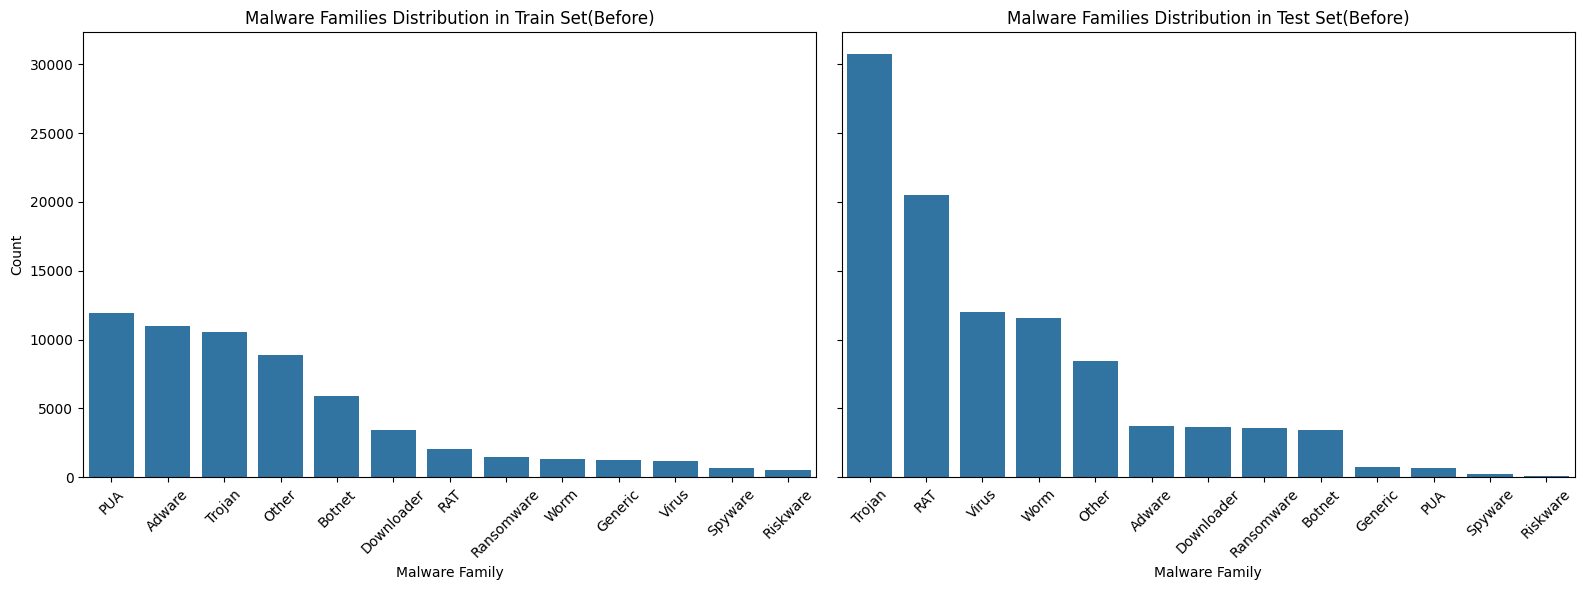

In [ ]:
# (Before) Plot the malware families distribution in training and testing data

# Get value counts
malware_train_class = malware_train_set_cleaned["avclass_grouped"].value_counts()
malware_test_class = malware_test_set_cleaned["avclass_grouped"].value_counts()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot for train set
sns.barplot(ax=axes[0], x=malware_train_class.index, y=malware_train_class.values)
axes[0].set_title("Malware Families Distribution in Train Set(Before)")
axes[0].set_xlabel("Malware Family")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# Plot for test set
sns.barplot(ax=axes[1], x=malware_test_class.index, y=malware_test_class.values)
axes[1].set_title("Malware Families Distribution in Test Set(Before)")
axes[1].set_xlabel("Malware Family")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Exlclude some avclass_grouped class to deal with data imbalance
exclude_classes = ["Ransomware", "Worm", "Generic", "Virus", "Spyware", "Riskware", "RAT"]
malware_train_set_filtered = malware_train_set_cleaned[~malware_train_set_cleaned["avclass_grouped"].isin(exclude_classes)]
malware_test_set_filtered = malware_test_set_cleaned[~malware_test_set_cleaned["avclass_grouped"].isin(exclude_classes)]

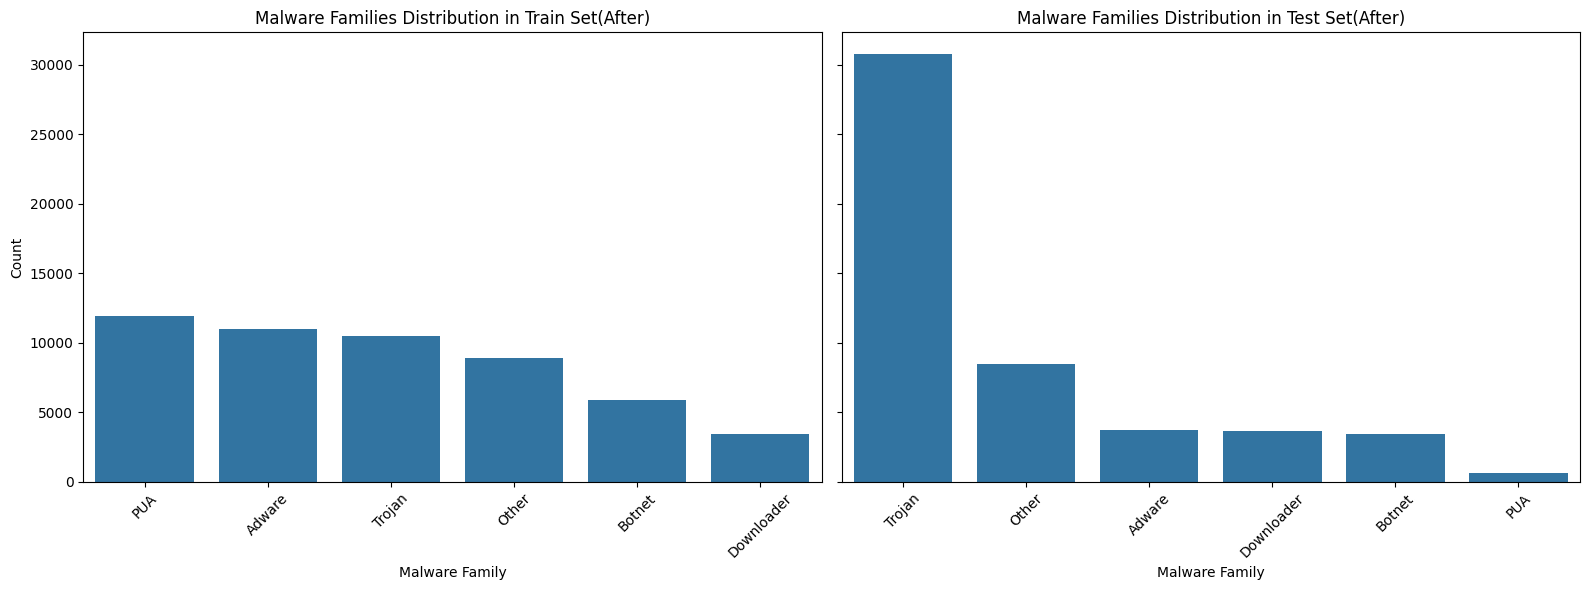

In [ ]:
# (After) Plot the malware families distribution in training and testing data

# Get value counts
malware_train_class = malware_train_set_filtered["avclass_grouped"].value_counts()
malware_test_class = malware_test_set_filtered["avclass_grouped"].value_counts()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot for train set
sns.barplot(ax=axes[0], x=malware_train_class.index, y=malware_train_class.values)
axes[0].set_title("Malware Families Distribution in Train Set(After)")
axes[0].set_xlabel("Malware Family")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# Plot for test set
sns.barplot(ax=axes[1], x=malware_test_class.index, y=malware_test_class.values)
axes[1].set_title("Malware Families Distribution in Test Set(After)")
axes[1].set_xlabel("Malware Family")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

6. **Separate the features (X) and target variable (Y) from the dataset**

*   Both 'sha256' and 'md5' are hash values used to identify files, similar to a file's fingerprint. They do not contribute to distinguishing malware families, so we removed them from x.
*   'avclass_grouped' and 'avclass' are our y (target labels), so we also removed them from x.
*   Since we are only using data with 'label' = 1, all labels are 1 and the column no longer provides any informational value. Therefore, we removed it from x as well.
*   The columns 'appeared', 'byteentropy', 'section', 'datadirectories', and 'exports' were excluded from the model during the earlier feature selection process, based on recommendations from ChatGPT.

In [ ]:
X_train_full = malware_train_set_filtered.drop(columns=['avclass', 'label','sha256','md5','avclass_grouped','appeared','byteentropy', 'section', 'datadirectories', 'exports'])
y_train_full = malware_train_set_filtered['avclass_grouped']

X_test = malware_test_set_filtered.drop(columns=['avclass', 'label','sha256','md5','avclass_grouped','appeared','byteentropy', 'section', 'datadirectories', 'exports'])
y_test = malware_test_set_filtered['avclass_grouped']

7. **Encode the target variable**

   Since our target variable (avclass_grouped) is categorical, we need to convert it into numerical values, as most models (such as CNNs) cannot process string data directly.

In [ ]:
# Encode y
le = LabelEncoder()
y_train_full_encoded = le.fit_transform(y_train_full)
y_test_encoded = le.transform(y_test)

print(le.classes_)

['Adware' 'Botnet' 'Downloader' 'Other' 'PUA' 'Trojan']


8. **Split the training dataset into training and validation sets**

In [ ]:
# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full_encoded, test_size=0.2, random_state=100
)

9. **Deal with data imbalance**

   The class distribution in the training dataset is imbalanced, with sample counts ranging from 2,682 to 9,566 across different classes. This imbalance can cause the model to be biased toward majority classes, leading to poor performance on underrepresented classes and overall reduced generalization. To address this, we apply SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic samples for minority classes, ensuring a more balanced training set and enabling the model to learn equally from all classes.

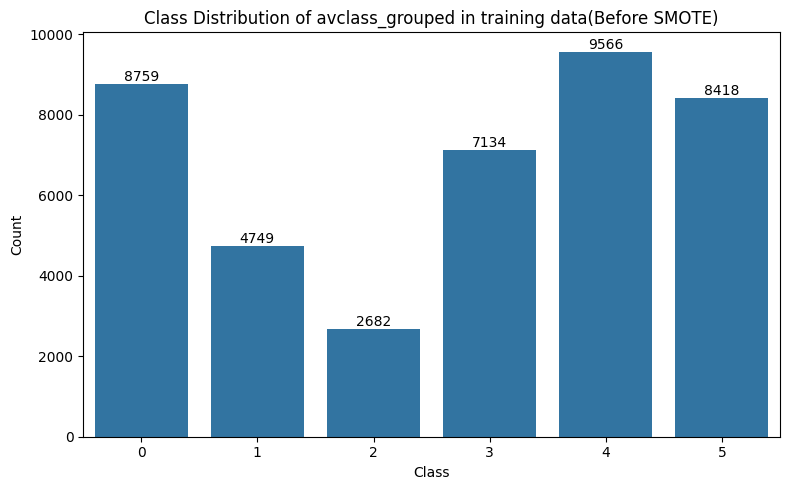

In [ ]:
# Plot the distribution of avclass_grouped in training data (Before SMOTE)
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=y_train)

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        str(count),
        (p.get_x() + p.get_width() / 2, count),
        ha='center',
        va='bottom'
    )

plt.title("Class Distribution of avclass_grouped in training data(Before SMOTE)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
# SMOTE the training dataset
smote = SMOTE(random_state=100)

non_numeric_cols = X_train_full.select_dtypes(exclude=["number"]).columns
X_train_filtered = X_train.drop(columns=non_numeric_cols)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

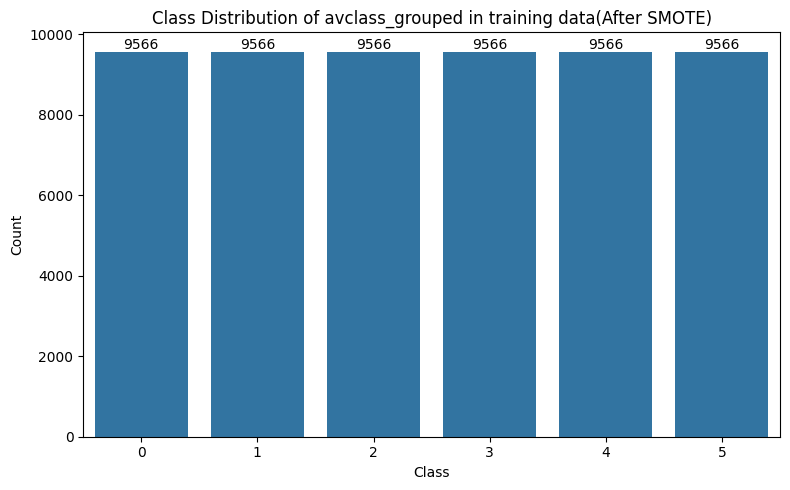

In [ ]:
# Plot the distribution of avclass_grouped in training data  (After SMOTE)
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=y_resampled)

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        str(count),
        (p.get_x() + p.get_width() / 2, count),
        ha='center',
        va='bottom'
    )

plt.title("Class Distribution of avclass_grouped in training data(After SMOTE)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

10. **Scaling the Data**

   The training dataset contains features with significantly different scales—for example, general_size ranges up to 150 million, while many binary features range from 0 to 1. This variation in magnitude can negatively impact models that rely on distance or gradient calculations, such as neural networks, causing them to disproportionately weight high-magnitude features. To address this, we apply feature scaling to standardize the input data, ensuring that all features contribute more equally to the learning process.

In [ ]:
X_resampled.describe()

,general_size,general_vsize,general_has_debug,general_exports,general_imports,general_has_relocations,general_has_resources,general_has_signature,general_has_tls,general_symbols,...,DLL,EXECUTABLE_IMAGE,LARGE_ADDRESS_AWARE,LINE_NUMS_STRIPPED,LOCAL_SYMS_STRIPPED,NET_RUN_FROM_SWAP,RELOCS_STRIPPED,REMOVABLE_RUN_FROM_SWAP,SYSTEM,UP_SYSTEM_ONLY
count,5.739600e+04,5.739600e+04,57396.000000,57396.000000,57396.000000,57396.000000,57396.000000,57396.000000,57396.000000,57396.000000,...,57396.000000,57396.0,57396.000000,57396.000000,57396.000000,57396.000000,57396.000000,57396.000000,57396.000000,57396.000000
mean,1.855720e+06,2.488154e+06,0.273172,5.629330,142.151735,0.581190,0.883232,0.198080,0.556816,11.839449,...,0.023782,1.0,0.025890,0.575179,0.557809,0.004513,0.413653,0.005732,0.001969,0.000105
std,2.430012e+06,7.969156e+06,0.445592,83.566959,173.347450,0.493368,0.321146,0.398556,0.496766,248.054602,...,0.152371,0.0,0.158809,0.494320,0.496651,0.067024,0.492492,0.075494,0.044328,0.010224
min,2.048000e+03,5.120000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.548160e+05,2.990080e+05,0.000000,0.000000,15.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.130344e+06,1.134592e+06,0.000000,0.000000,74.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.261130e+06,2.072576e+06,1.000000,0.000000,247.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.546152e+08,8.953119e+08,1.000000,5325.000000,3015.000000,1.000000,1.000000,1.000000,1.000000,20168.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Scaled the data with SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Scaled the data without SMOTE
scaler_noSMOTE = StandardScaler()
X_train_scaled_noSMOTE = scaler_noSMOTE.fit_transform(X_train)
X_val_scaled_noSMOTE = scaler_noSMOTE.transform(X_val)
X_test_scaled_noSMOTE = scaler_noSMOTE.transform(X_test)

In [ ]:
# Final variables:
# un-scaled: X_resampled, X_val, y_resampled, y_val, X_test, y_test_encoded
# scaled(SMOTE): X_train_scaled, X_val_scaled, y_resampled, y_val, X_test_scaled, y_test_encoded
# scaled(no SMOTE): X_train_scaled_noSMOTE, X_val_scaled_noSMOTE, y_resampled, y_val, X_test_scaled_noSMOTE, y_test_encoded

## **Decision Tree/Random Forest**


**Model Overview**

* Model Training with GridSearchCV
  * 5-fold cross-validation
  * Scoring metric: "f1_weighted" to handle class imbalance

* Decision Tree
  * Best Cross-Validation Accuracy: 90.53%
  * Best Hyperparameters: The model used entropy impurity to measure split quality. The tree is allowed to grow up to 30 levels deep (complex enough). Every leaf node must contain at least 5 samples. A node must have at least 2 samples to be split.

* Random Forest
  * Best Cross-Validation Accuracy: 93.7%
  * Best Hyperparameters: Using the square root of the total number of features leads to better generalization. The tree is allowed to grow up to 30 levels deep (complex enough) and it will build 200 decision trees. Every leaf node must contain at least 1 samples. A node must have at least 2 samples to be split.

In [ ]:
# Check if column has string values
print(X_resampled.dtypes[X_resampled.dtypes == 'object'])
print(X_test.dtypes[X_test.dtypes == 'object'])

Series([], dtype: object)
Series([], dtype: object)


In [ ]:
# Decision Tree with 5-fold cross-validation
# Initialize the classifier (with class_weight to handle imbalance)
clf_dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
param_grid_dt = {
    'criterion': ['gini','entropy'],  # 'gini' is faster
    'max_depth': [5, 10, 15, 20, 30],
    'min_samples_leaf': [5, 10, 20, 50],
    'min_samples_split': [2, 10, 20]
}

# Set up GridSearchCV with 5-fold cross-validation
# f1_weighted for imbalanced classification
grid_search = GridSearchCV(
  clf_dt, param_grid_dt, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

best_dt_clf = grid_search.best_estimator_
best_score_dt = grid_search.best_score_
best_params_dt = grid_search.best_params_

# Print the best parameters and score
print(f"Best Cross-Validation Accuracy of Decision Tree: {best_score_dt:.4f}")
print(f"Best Hyperparameters of Decision Tree: {best_params_dt}")

Best Cross-Validation Accuracy of Decision Tree: 0.9053
Best Hyperparameters of Decision Tree: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [ ]:
# Save label name mapping
label_names = le.classes_

# Predicting the test set results
y_predict_dt = best_dt_clf.predict(X_test)
accuracy = accuracy_score(y_test_encoded, y_predict_dt)
print("Decision Tree Classification Report:")
print(classification_report(y_test_encoded,y_predict_dt,target_names=label_names))
print(f"Decision Tree Accuracy: {accuracy:.2%}")

Decision Tree Classification Report:
              precision    recall  f1-score   support

      Adware       0.21      0.09      0.13      3732
      Botnet       0.32      0.32      0.32      3448
  Downloader       0.35      0.84      0.50      3688
       Other       0.23      0.61      0.33      8437
         PUA       0.63      0.40      0.49       663
      Trojan       0.80      0.35      0.49     30785

    accuracy                           0.41     50753
   macro avg       0.42      0.44      0.38     50753
weighted avg       0.59      0.41      0.42     50753

Decision Tree Accuracy: 40.87%


<Figure size 1000x800 with 0 Axes>

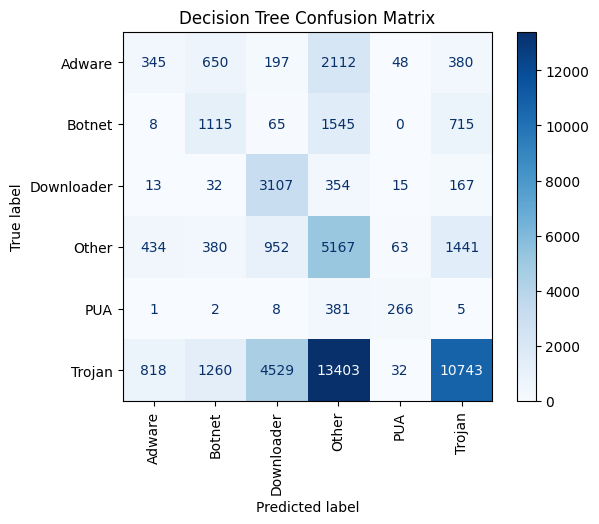

In [ ]:
# Display confusion matrix
cm_dt = confusion_matrix(y_test_encoded, y_predict_dt)

plt.figure(figsize=(10, 8))
disp_dt = ConfusionMatrixDisplay(
  confusion_matrix=cm_dt, display_labels=label_names)
disp_dt.plot(xticks_rotation=90, cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.show()

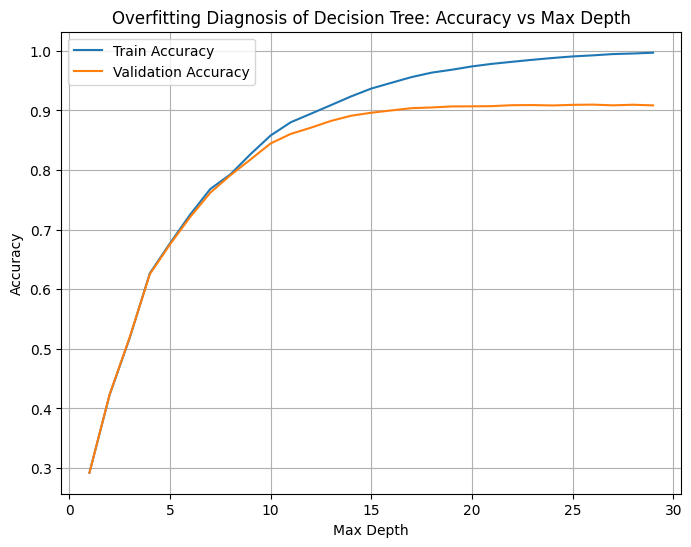

In [ ]:
# Plotting Model Complexity vs Accuracy to do overfitting diagnostics
# Define the range of model complexity to test
max_depths = range(1, 30)
train_accuracies = []
val_accuracies = []

for depth in max_depths:
    model_dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model_dt.fit(X_resampled, y_resampled)

    # Training accuracy
    train_accuracy = model_dt.score(X_resampled, y_resampled)

    # Validation accuracy using 5-fold cross-validation
    val_accuracy = cross_val_score(
      model_dt, X_resampled, y_resampled, cv=5).mean()

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(max_depths, train_accuracies, label='Train Accuracy')
plt.plot(max_depths, val_accuracies, label='Validation Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Overfitting Diagnosis of Decision Tree: Accuracy vs Max Depth')
plt.legend()
plt.grid(True)
plt.show()

**Decision Tree Model Performance**

The Decision Tree model achieved a validation accuracy of 40.87% which shows limited effectiveness in malware family classification. While Downloader were classified with relative higher success, Adware performed poorly and frequent misclassification into the Other category that indicated difficulty distinguishing overlapping families. Although Trojan precision was high, recall remained low.

Overfitting was observed beyond a max depth of 15 where training accuracy increased but validation accuracy plateaued around 90%. This overfitting behavior emphasizes the need for model regularization and more robust feature representations. Future work should explore ensemble methods such as Random Forests or Boosting along with enhanced feature engineering to improve generalization and classification effectiveness.

In [ ]:
# Random Forest
# Initialize the model
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
    'max_features': ['sqrt', 'log2']} # Features to consider when splitting

# Set up GridSearchCV with 5-fold cross-validation
# f1_weighted for imbalanced classification
grid_search_rf = GridSearchCV(
  rf_clf, param_grid_rf, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search_rf.fit(X_resampled, y_resampled)

best_rf_clf = grid_search_rf.best_estimator_
best_score_rf = grid_search_rf.best_score_
best_params_rf = grid_search_rf.best_params_

# Print the best parameters and score
print(f"Best Cross-Validation Accuracy of Random Forest: {best_score_rf:.4f}")
print(f"Best Hyperparameters of Random Forest: {best_params_rf}")

Best Cross-Validation Accuracy of Random Forest: 0.9370
Best Hyperparameters of Random Forest: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# Save label name mapping
label_names = le.classes_

# Predicting the test set results
y_predict_rf = best_rf_clf.predict(X_test)
accuracy_rf = accuracy_score(y_test_encoded, y_predict_rf)
print("Random Forest Classification Report:")
print(classification_report(y_test_encoded,y_predict_rf,target_names=label_names))
print(f"Random Forest Accuracy: {accuracy_rf:.2%}")

Random Forest Classification Report:
              precision    recall  f1-score   support

      Adware       0.54      0.27      0.36      3732
      Botnet       0.98      0.28      0.44      3448
  Downloader       0.88      0.84      0.86      3688
       Other       0.24      0.95      0.38      8437
         PUA       0.96      0.37      0.53       663
      Trojan       0.90      0.30      0.45     30785

    accuracy                           0.44     50753
   macro avg       0.75      0.50      0.50     50753
weighted avg       0.77      0.44      0.46     50753

Random Forest Accuracy: 44.47%


<Figure size 1000x800 with 0 Axes>

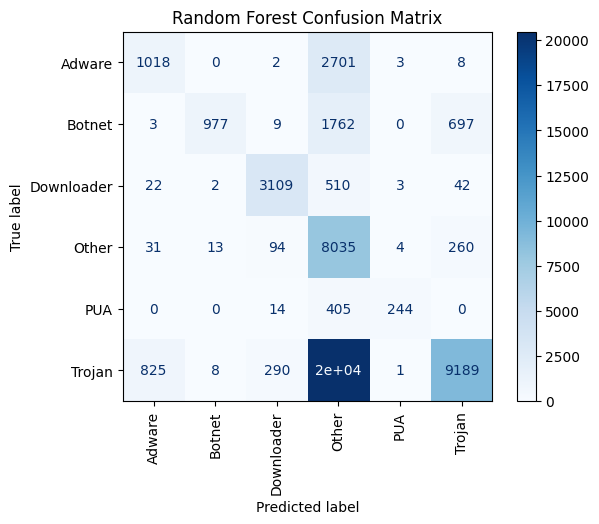

In [ ]:
# Display confusion matrix
cm_rf = confusion_matrix(y_test_encoded, y_predict_rf)

plt.figure(figsize=(10, 8))
disp_rf = ConfusionMatrixDisplay(
  confusion_matrix=cm_rf, display_labels=label_names)
disp_rf.plot(xticks_rotation=90, cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

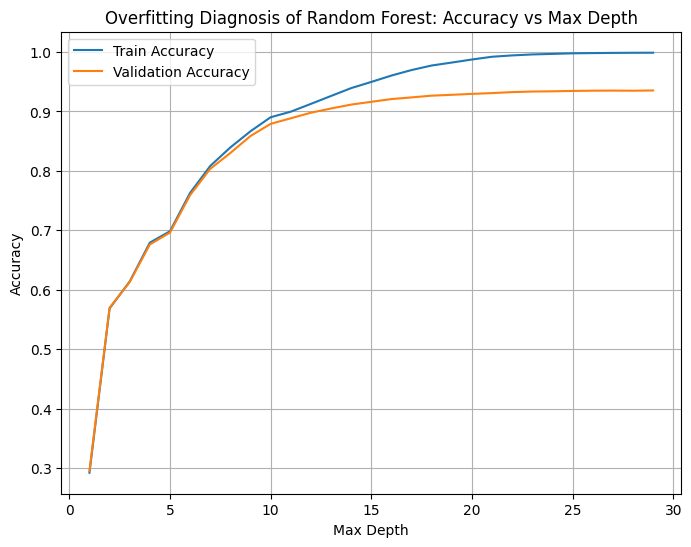

In [ ]:
from sklearn.model_selection import cross_val_score
# Plotting Model Complexity vs Accuracy to do overfitting diagnostics
# Define the range of model complexity to test
max_depths = range(1, 30)
train_accuracies = []
val_accuracies = []

for depth in max_depths:
    model_rf = RandomForestClassifier(max_depth=depth, random_state=42)
    model_rf.fit(X_resampled, y_resampled)

    # Training accuracy
    train_accuracy = model_rf.score(X_resampled, y_resampled)

    # Validation accuracy using 5-fold cross-validation
    val_accuracy = cross_val_score(
      model_rf, X_resampled, y_resampled, cv=5).mean()

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(max_depths, train_accuracies, label='Train Accuracy')
plt.plot(max_depths, val_accuracies, label='Validation Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Overfitting Diagnosis of Random Forest: Accuracy vs Max Depth')
plt.legend()
plt.grid(True)
plt.show()

**Random Forest Model Performance**

The Random Forest classifier achieved a validation accuracy of 44.47%, similar to the Decision Tree model. The model classified the Downloader family effectively, achieving an F1-score of 0.86, but struggled with Adware, PUA and Trojan classes due to low recall. The Other category showed high recall but low precision, indicating frequent misclassification. Although Random Forest improved stability compared to a single Decision Tree, static features alone remained insufficient for distinguishing between overlapping malware families. Future improvements could involve enhanced feature sets or integration of dynamic analysis.

Overfitting analysis showed that the Random Forest generalized well up to a max depth of approximately 15. After that point, mild overfitting occurred as training accuracy continued to increase while validation accuracy plateaued around 93%. These results suggest that Random Forest improved stability and classification performance compared to a single Decision Tree. However, further enhancements in feature diversity or integration of dynamic behavior data may be needed to achieve stronger classification robustness.

In [ ]:
# Extract Feature Importances

# Get feature names
feature_names = X_resampled.columns

# Get feature importances from the best model
importances = best_rf_clf.feature_importances_

# Create a DataFrame to sort and display
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
4,general_imports,0.032900
1,general_vsize,0.028195
10,header_timestamp,0.026766
112,strings_avlength,0.022041
103,hist_92,0.019506
...,...,...
127,C,0.000000
135,P,0.000000
134,O,0.000000
147,EXECUTABLE_IMAGE,0.000000


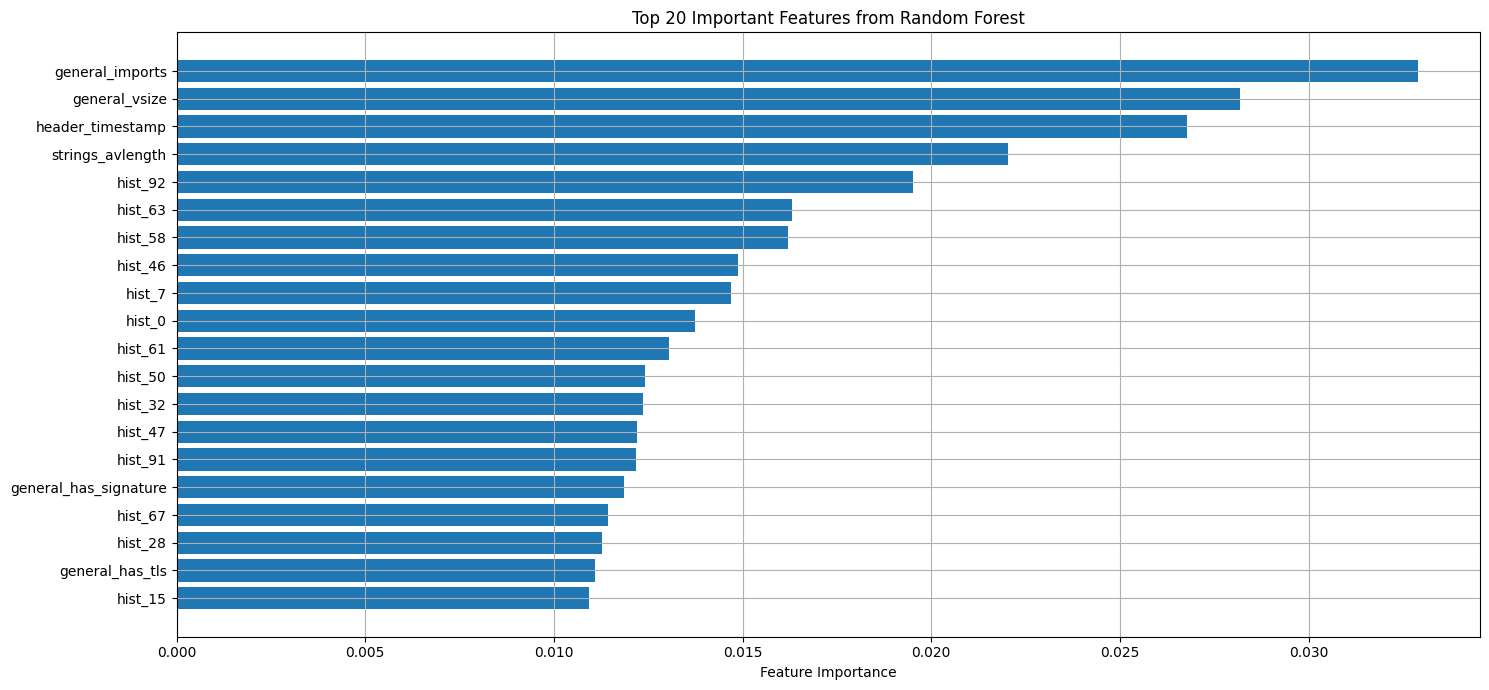

In [ ]:
# Display Top 20 Important Features
# Select top 20 features
top_n = 20
top_features = feature_importance_df.head(top_n)

# Plot
plt.figure(figsize=(15, 7))
plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1])
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Important Features from Random Forest')
plt.tight_layout()
plt.grid(True)
plt.show()

**Feature Importance Result**

The Random Forest model identified **general_imports, and general_vsize, header_timestamp,** as the most discriminative features for malware family classification. Byte distribution metrics and string-based features further contributed significantly to the model's decisions, highlighting the value of static file structure and metadata in distinguishing malware families.

# **CNN**

**Model Overview**

We built and trained a one-dimensional convolutional neural network (CNN) for a 6-class classification task using SMOTE-balanced training data. The model architecture consists of:

*   A Conv1D layer for feature extraction

*   A GlobalMaxPooling1D layer

*   Three fully connected hidden layers (Dense)

*   A softmax output layer for multi-class prediction

The model was trained on standardized input features, with EarlyStopping to prevent overfitting and ModelCheckpoint to save the best-performing model (based on validation accuracy) as "best_cnn_model.keras".

In [ ]:
# CNN model (with SMOTE data)
input_dim = X_train_scaled.shape[1]

cnn = models.Sequential()

cnn.add(Input(shape=(input_dim,)))
cnn.add(layers.Reshape((input_dim, 1)))
cnn.add(layers.Conv1D(128, kernel_size=2, activation="relu"))
cnn.add(layers.GlobalMaxPooling1D())
cnn.add(layers.Dense(128, activation="relu"))
cnn.add(layers.Dense(64, activation="relu"))
cnn.add(layers.Dense(32, activation="relu"))
cnn.add(layers.Dense(6, activation="softmax"))

cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_cnn_model.keras", monitor='val_accuracy', save_best_only=True)

history = cnn.fit(
    X_train_scaled, y_resampled,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.4482 - loss: 1.4695 - val_accuracy: 0.5489 - val_loss: 1.0857
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.6058 - loss: 1.0094 - val_accuracy: 0.6529 - val_loss: 0.8768
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.6639 - loss: 0.8812 - val_accuracy: 0.6849 - val_loss: 0.8400
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.6848 - loss: 0.8173 - val_accuracy: 0.7104 - val_loss: 0.7738
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.6989 - loss: 0.7901 - val_accuracy: 0.7122 - val_loss: 0.7684
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.7082 - loss: 0.7597 - val_accuracy: 0.7215 - val_loss: 0.7250
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.7214 - loss: 0.7364 - val_accuracy: 0.7333 - val_loss: 0.7306
Epoch 8/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.7314 - loss: 0.7154 - 

In [ ]:
best_epoch = np.argmax(history.history['val_accuracy'])
best_val_acc = history.history['val_accuracy'][best_epoch]

print(f"✅ Best model saved at epoch {best_epoch+1} with val_accuracy = {best_val_acc:.4f}")

✅ Best model saved at epoch 30 with val_accuracy = 0.7945


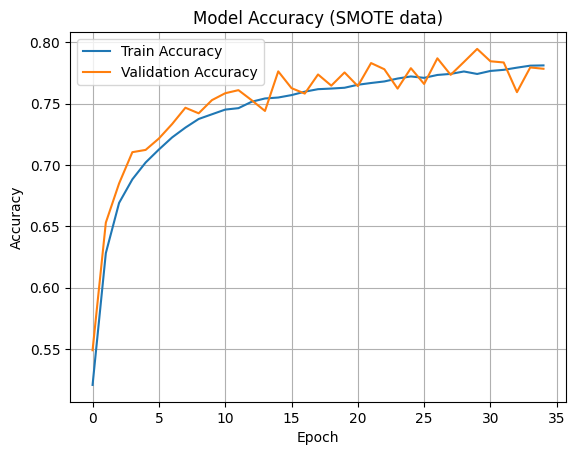

In [ ]:
# Accuracy (SMOTE)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (SMOTE data)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

1587/1587 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
✅ Test Accuracy: 0.2751

📄 Classification Report (SMOTE data):
              precision    recall  f1-score   support

           0       0.19      0.35      0.25      3732
           1       0.17      0.03      0.04      3448
           2       0.30      0.81      0.44      3688
           3       0.17      0.53      0.26      8437
           4       0.22      0.22      0.22       663
           5       0.69      0.16      0.26     30785

    accuracy                           0.28     50753
   macro avg       0.29      0.35      0.25     50753
weighted avg       0.50      0.28      0.26     50753



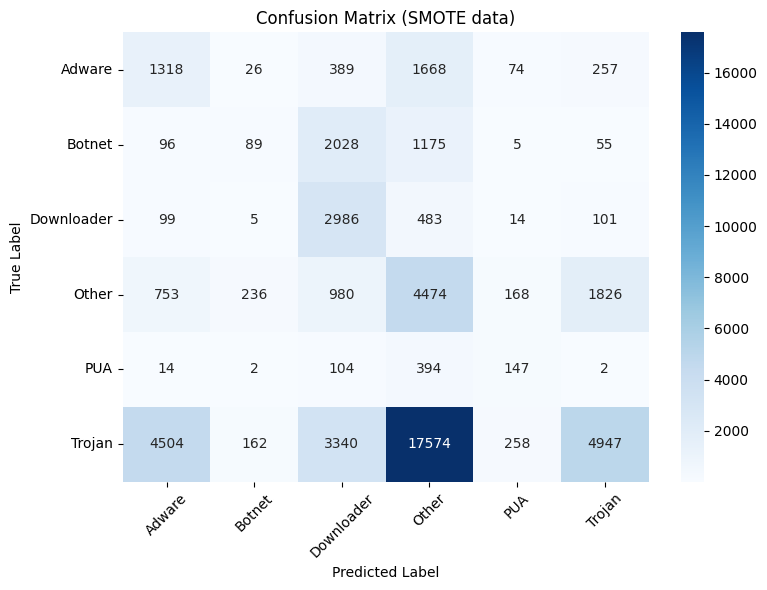

In [ ]:
best_model = load_model("best_cnn_model.keras")

y_pred_probs = best_model.predict(X_test_scaled)
y_pred = y_pred_probs.argmax(axis=1)

test_acc = accuracy_score(y_test_encoded, y_pred)
print("✅ Test Accuracy:", round(test_acc, 4))

# Classification Report
print("\n📄 Classification Report (SMOTE data):")
print(classification_report(y_test_encoded, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)
class_names = le.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (SMOTE data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Model Performance**

The best-performing model achieved a validation accuracy of 0.7945, but its test accuracy dropped to only 0.2751. This gap may be attributed to the highly imbalanced test set—class 5(Trojan) alone accounts for over 30,000 samples (~60%), while classes 0–4 combined are fewer than 20,000. Such imbalance can lead to biased performance on the test set. Additionally, while SMOTE helped the model learn to identify underrepresented classes, the synthetic nature of SMOTE data may have caused the model to overfit to artificial patterns, reducing its generalization ability to real-world data.

**SMOTE Impact: Validation vs. Training Accuracy**

Interestingly, during training with SMOTE, we observed that validation accuracy often exceeded training accuracy, which is unusual. We hypothesized this might be caused by the SMOTE-generated data, so we trained another version without SMOTE for comparison.

In [ ]:
# CNN model (with no SMOTE data)
input_dim = X_train_scaled_noSMOTE.shape[1]

cnn = models.Sequential()

cnn.add(Input(shape=(input_dim,)))
cnn.add(layers.Reshape((input_dim, 1)))
cnn.add(layers.Conv1D(128, kernel_size=2, activation="relu"))
cnn.add(layers.GlobalMaxPooling1D())
cnn.add(layers.Dense(128, activation="relu"))
cnn.add(layers.Dense(64, activation="relu"))
cnn.add(layers.Dense(32, activation="relu"))
cnn.add(layers.Dense(6, activation="softmax"))

cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_cnn_model_noSMOTE.keras", monitor='val_accuracy', save_best_only=True)

history_noSMOTE = cnn.fit(
    X_train_scaled_noSMOTE, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.3990 - loss: 1.5440 - val_accuracy: 0.5979 - val_loss: 1.1766
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.6072 - loss: 1.0828 - val_accuracy: 0.6711 - val_loss: 0.9549
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.6744 - loss: 0.9095 - val_accuracy: 0.6729 - val_loss: 0.8850
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.6892 - loss: 0.8382 - val_accuracy: 0.6657 - val_loss: 0.9232
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.7096 - loss: 0.7987 - val_accuracy: 0.6942 - val_loss: 0.8493
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.7306 - loss: 0.7538 - val_accuracy: 0.7031 - val_loss: 0.8262
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.7276 - loss: 0.7470 - val_accuracy: 0.7211 - val_loss: 0.7928
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.7389 - loss: 0.7224 - 

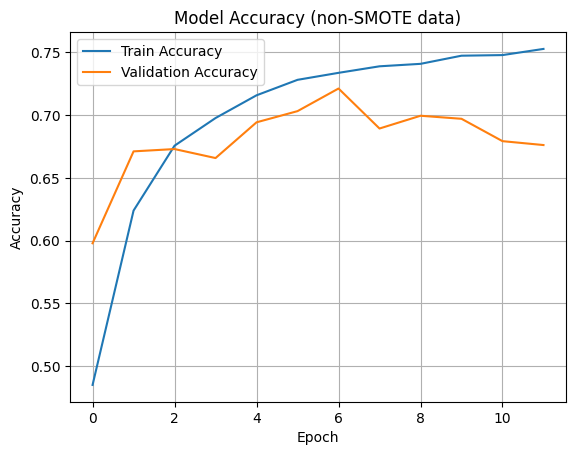

In [ ]:
# Accuracy (no SMOTE)
plt.plot(history_noSMOTE.history['accuracy'], label='Train Accuracy')
plt.plot(history_noSMOTE.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (non-SMOTE data)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

1587/1587 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
✅ Test Accuracy: 0.2447

📄 Classification Report (non-SMOTE data):
              precision    recall  f1-score   support

           0       0.15      0.34      0.21      3732
           1       0.10      0.03      0.04      3448
           2       0.07      0.03      0.04      3688
           3       0.15      0.53      0.23      8437
           4       0.03      0.03      0.03       663
           5       0.69      0.21      0.32     30785

    accuracy                           0.24     50753
   macro avg       0.20      0.19      0.14     50753
weighted avg       0.47      0.24      0.26     50753



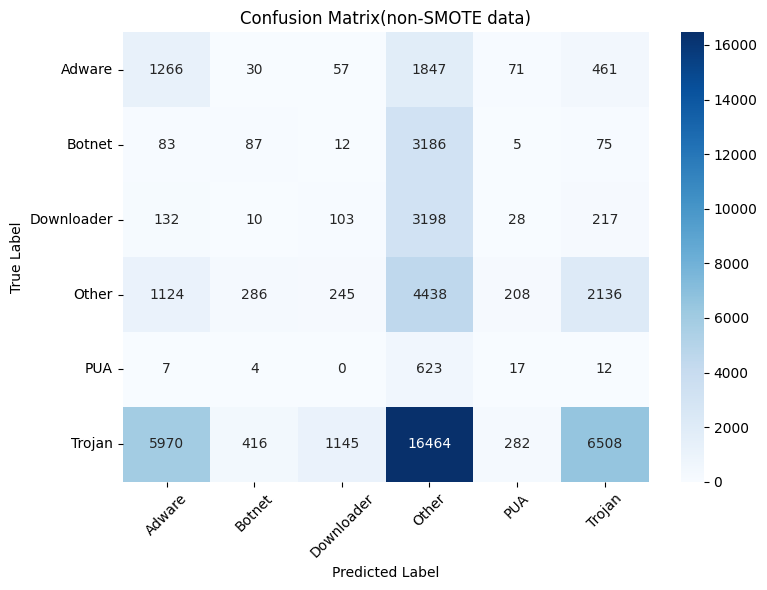

In [ ]:
best_model = load_model("best_cnn_model_noSMOTE.keras")

y_pred_probs = best_model.predict(X_test_scaled_noSMOTE)
y_pred = y_pred_probs.argmax(axis=1)

test_acc = accuracy_score(y_test_encoded, y_pred)
print("✅ Test Accuracy:", round(test_acc, 4))

# Classification Report
print("\n📄 Classification Report (non-SMOTE data):")
print(classification_report(y_test_encoded, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)
class_names = le.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix(non-SMOTE data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The results showed that:

*   In the non-SMOTE model, validation accuracy remained more consistently lower than training accuracy

*   The SMOTE-based model required more epochs to reach its best performance but surpassed 0.75 val_accuracy starting at epoch 10, peaking at 0.7945 at epoch 30

*   In contrast, the non-SMOTE model only reached a maximum validation accuracy of 0.7211